# Sentiment analysis of Bluesky posts

In [9]:
import pandas as pd
import numpy as np
import snscrape.modules.twitter as sntwitter
from datetime import datetime
from tqdm.notebook import tqdm_notebook
import seaborn as sns
import matplotlib.pyplot as plt

## tweets

### load tweets

In [545]:
# loading museum visitor data - field museum??
import glob

path = 'tweets'
filenames = glob.glob(path + "/bristol*.csv")

dfs = []
for f in filenames:
    df = pd.read_csv(f)
    dfs.append(df)

tweets = pd.concat(dfs, ignore_index=True)

# tweets.head()
len(tweets)



6281

### Remove self-tweets by the museum

In [839]:
# tweets = tweets[tweets['Handle']!='@bristolmuseum']

tweets[tweets['Handle']!='@bristolmuseum'].head()

# tweets.groupby('Handle').size().sort_values(ascending=False)

# text = tweets[tweets['Handle']=='@bristolmuseum']['Content']

# text = text.str.cat(sep='\n')
# text

# re.findall('[Nn]ew exhibit', text)
# new_exhibit_texts = re.findall(r'((.*?)[Nn]ew exhibit(.*))', text)
# new_exhibit_texts

# print(len(tweets))
# tweets.head()


,Name,Handle,Timestamp,Verified,Content,Comments,Retweets,Likes,Analytics,Tags,Mentions,Emojis,Profile Image,Tweet Link,Tweet ID,date,Content_cleaned,Sentiment,Sentiment_value,month
5,Rhian Rowson,@RhianRowson,2017-12-28T12:32:50.000Z,False,Virginia Woolf's fascination with insect life:...,0,13.0,24.0,0,[],['@bristolmuseum'],[],https://pbs.twimg.com/profile_images/606133212...,https://x.com/RhianRowson/status/9463582782163...,tweet_id:946358278216351744,2017-12-28,Virginia Woolf's fascination with insect life:...,positive,0.7964,2017-12
9,RM,@RMAjayi,2017-12-27T12:30:01.000Z,False,"Thanks to a second photo from , I traced 1923 ...",2,1.0,2.0,0,[],['@zara_abd'],[],https://pbs.twimg.com/profile_images/971546387...,https://x.com/RMAjayi/status/945995181874171904,tweet_id:945995181874171904,2017-12-27,"Thanks to a second photo from , I traced 1923 ...",positive,0.1531,2017-12
14,Somaliland inBristol,@SLand_inBristol,2017-12-26T14:36:42.000Z,False,Never seen it before but you could approach st...,0,0.0,0.0,0,[],[],[],https://pbs.twimg.com/profile_images/731878241...,https://x.com/SLand_inBristol/status/945664672...,tweet_id:945664672040177665,2017-12-26,Never seen it before but you could approach st...,positive,0.7684,2017-12
15,Colin Moody,@MoodyColin,2017-12-26T13:54:59.000Z,False,Review of the year. February. Chinese New Year...,0,0.0,0.0,0,[],[],[],https://pbs.twimg.com/profile_images/147163090...,https://x.com/MoodyColin/status/94565417608801...,tweet_id:945654176088018945,2017-12-26,Review of the year. February. Chinese New Year...,neutral,0.0000,2017-12
20,Gary,@Garywalsh_,2017-12-24T21:05:44.000Z,False,absolutely loving the Bristol Museum Christma...,0,0.0,1.0,0,[],['@bristolmuseum'],[],https://pbs.twimg.com/profile_images/152847887...,https://x.com/Garywalsh_/status/94503780212276...,tweet_id:945037802122764289,2017-12-24,absolutely loving the Bristol Museum Christma...,positive,0.7477,2017-12


### Plot tweets over time

In [840]:
print("There are {} observations and {} features in this dataset. \n".format(tweets.shape[0],tweets.shape[1]))

There are 6281 observations and 20 features in this dataset. 



### make a wordcloud

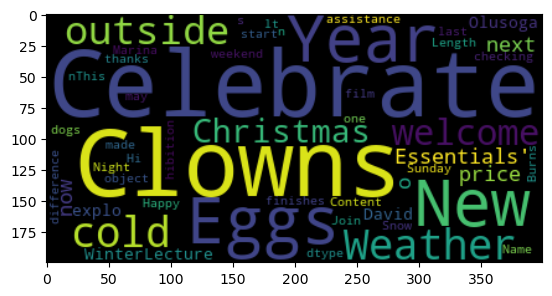

In [841]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

text = str(tweets['Content'])
# text = str(df.Content)

text = text.replace('Bristol Museum', '')
# text = re.sub('[Nn]atural|[Mm]useum|[Hh]istory', '', text)
# text = re.sub('[Nn]atural', '', text)
# text = re.sub('[Nn]atural', '', text)

wc = WordCloud().generate(text)

plt.imshow(wc, interpolation='bilinear')

plt.savefig('figs/wordcloud.png', dpi=300)


## Do sentiment analysis on tweets



In [573]:
# sentiment analysis functions

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
import re

def get_post_sentiment(post):
    # create TextBlob object of passed bluesky post text
    analysis = TextBlob(post)
    # set sentiment
    if analysis.sentiment.polarity > 0:
        return 'positive'
    elif analysis.sentiment.polarity == 0:
        return 'neutral'
    else:
        return 'negative'

def get_post_sentiment_value(post):
    # create TextBlob object of passed bluesky post text
    analysis = TextBlob(post)
    # set sentiment
    return analysis.sentiment.polarity

def get_post_sentiment_vad(post):
    # create TextBlob object of passed bluesky post text
    analyzer = SentimentIntensityAnalyzer()
    vs = analyzer.polarity_scores(post)
    # set sentiment
    if vs['compound'] > 0:
        return 'positive'
    elif vs['compound'] == 0:
        return 'neutral'
    else:
        return 'negative'

def get_post_sentiment_vad_value(post):
    # create TextBlob object of passed bluesky post text
    analyzer = SentimentIntensityAnalyzer()
    vs = analyzer.polarity_scores(post)
    # set sentiment
    return vs['compound']

# Remove URLs
def clean_tweets(text):
    return(re.sub(r'http\S+', '', text))


In [574]:
tweets['Content_cleaned'] = tweets['Content'].apply(clean_tweets)

tweets.loc[:, ('Content_cleaned','Content')]

,Content_cleaned,Content
0,The Weather is cold outside but the welcome is...,The Weather is cold outside but the welcome is...
1,All 'Christmas Essentials' are now 1/2 price o...,All 'Christmas Essentials' are now 1/2 price o...
2,In our next #WinterLecture David Olusoga explo...,In our next #WinterLecture David Olusoga explo...
3,*assistance dogs that is! ^lt,*assistance dogs that is! ^lt
4,"Hi Marina, thanks for checking - however only ...","Hi Marina, thanks for checking - however only ..."
...,...,...
6276,Celebrate the last weekend of Clowns: the Eggs...,Celebrate the last weekend of Clowns: the Eggs...
6277,Our clowns eggs-hibition finishes on Sunday so...,Our clowns eggs-hibition finishes on Sunday so...
6278,I may have only made one film but I did start ...,I may have only made one film but I did start ...
6279,Celebrate Burns Night with a difference! Join ...,Celebrate Burns Night with a difference! Join ...


In [575]:
tweets['Sentiment'] = tweets['Content_cleaned'].apply(get_post_sentiment_vad)
tweets['Sentiment_value'] = tweets['Content_cleaned'].apply(get_post_sentiment_vad_value)
tweets.head()

# save output
# tweets.to_csv('data/processed/FieldMuseum_2023-03-25_2024-09-11.csv', index=False)

,Name,Handle,Timestamp,Verified,Content,Comments,Retweets,Likes,Analytics,Tags,Mentions,Emojis,Profile Image,Tweet Link,Tweet ID,date,Content_cleaned,Sentiment,Sentiment_value
0,Bristol Museum & Art Gallery,@bristolmuseum,2017-12-30T09:05:08.000Z,False,The Weather is cold outside but the welcome is...,0,3,7,0,[],[],[],https://pbs.twimg.com/profile_images/164072706...,https://x.com/bristolmuseum/status/94703078324...,tweet_id:947030783243497472,2017-12-30,The Weather is cold outside but the welcome is...,positive,0.7783
1,Bristol Museum & Art Gallery,@bristolmuseum,2017-12-29T09:00:44.000Z,False,All 'Christmas Essentials' are now 1/2 price o...,1,2,5,0,[],[],[],https://pbs.twimg.com/profile_images/164072706...,https://x.com/bristolmuseum/status/94666729063...,tweet_id:946667290631770112,2017-12-29,All 'Christmas Essentials' are now 1/2 price o...,positive,0.6800
2,Bristol Museum & Art Gallery,@bristolmuseum,2017-12-28T16:00:55.000Z,False,In our next #WinterLecture David Olusoga explo...,0,0,8,0,['#WinterLecture'],[],[],https://pbs.twimg.com/profile_images/164072706...,https://x.com/bristolmuseum/status/94641064325...,tweet_id:946410643258822656,2017-12-28,In our next #WinterLecture David Olusoga explo...,positive,0.6786
3,Bristol Museum & Art Gallery,@bristolmuseum,2017-12-28T13:57:31.000Z,False,*assistance dogs that is! ^lt,0,0,0,0,[],[],[],https://pbs.twimg.com/profile_images/164072706...,https://x.com/bristolmuseum/status/94637958779...,tweet_id:946379587793096705,2017-12-28,*assistance dogs that is! ^lt,neutral,0.0000
4,Bristol Museum & Art Gallery,@bristolmuseum,2017-12-28T13:56:17.000Z,False,"Hi Marina, thanks for checking - however only ...",2,0,0,0,[],[],[],https://pbs.twimg.com/profile_images/164072706...,https://x.com/bristolmuseum/status/94637928036...,tweet_id:946379280363159552,2017-12-28,"Hi Marina, thanks for checking - however only ...",positive,0.4404


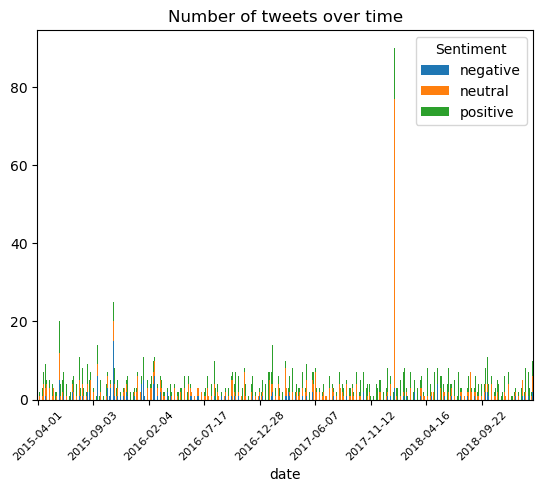

In [848]:
# now plot as a function of time and sentiment:

import seaborn as sns
import pandas as pd

tweets['date'] = pd.to_datetime(tweets['date']).dt.date

# Summarize number of rows by date and sentiment
summary_by_date = tweets.groupby([tweets['date'], 'Sentiment']).size().reset_index(name='counts')

# Line plot
# sns.lineplot(data=summary_by_date, x='date', y='counts', hue='Sentiment')
# plt.xticks(rotation=45, fontsize=8)

# Bar plot
summary_by_date.pivot(index='date', columns='Sentiment', values='counts').plot(kind='bar', stacked=True)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(nbins=12))

plt.xticks(rotation=45, fontsize=8)
plt.title('Number of tweets over time')

# save figure
plt.savefig('figs/timeline_sentiment_bristol.png', dpi=300)


In [849]:
# summary_by_date.sort_values('counts', ascending=False)
tweets.groupby(tweets['date']).size().sort_values(ascending=False)

date
2018-01-17    90
2017-10-16    40
2015-10-28    34
2017-12-24    30
2015-09-17    29
              ..
2016-10-31     1
2018-07-16     1
2015-05-01     1
2018-01-05     1
2017-03-06     1
Length: 1341, dtype: int64

In [850]:
tweets.head()

,Name,Handle,Timestamp,Verified,Content,Comments,Retweets,Likes,Analytics,Tags,Mentions,Emojis,Profile Image,Tweet Link,Tweet ID,date,Content_cleaned,Sentiment,Sentiment_value,month
0,Bristol Museum & Art Gallery,@bristolmuseum,2017-12-30T09:05:08.000Z,False,The Weather is cold outside but the welcome is...,0,3.0,7.0,0,[],[],[],https://pbs.twimg.com/profile_images/164072706...,https://x.com/bristolmuseum/status/94703078324...,tweet_id:947030783243497472,2017-12-30,The Weather is cold outside but the welcome is...,positive,0.7783,2017-12
1,Bristol Museum & Art Gallery,@bristolmuseum,2017-12-29T09:00:44.000Z,False,All 'Christmas Essentials' are now 1/2 price o...,1,2.0,5.0,0,[],[],[],https://pbs.twimg.com/profile_images/164072706...,https://x.com/bristolmuseum/status/94666729063...,tweet_id:946667290631770112,2017-12-29,All 'Christmas Essentials' are now 1/2 price o...,positive,0.6800,2017-12
2,Bristol Museum & Art Gallery,@bristolmuseum,2017-12-28T16:00:55.000Z,False,In our next #WinterLecture David Olusoga explo...,0,0.0,8.0,0,['#WinterLecture'],[],[],https://pbs.twimg.com/profile_images/164072706...,https://x.com/bristolmuseum/status/94641064325...,tweet_id:946410643258822656,2017-12-28,In our next #WinterLecture David Olusoga explo...,positive,0.6786,2017-12
3,Bristol Museum & Art Gallery,@bristolmuseum,2017-12-28T13:57:31.000Z,False,*assistance dogs that is! ^lt,0,0.0,0.0,0,[],[],[],https://pbs.twimg.com/profile_images/164072706...,https://x.com/bristolmuseum/status/94637958779...,tweet_id:946379587793096705,2017-12-28,*assistance dogs that is! ^lt,neutral,0.0000,2017-12
4,Bristol Museum & Art Gallery,@bristolmuseum,2017-12-28T13:56:17.000Z,False,"Hi Marina, thanks for checking - however only ...",2,0.0,0.0,0,[],[],[],https://pbs.twimg.com/profile_images/164072706...,https://x.com/bristolmuseum/status/94637928036...,tweet_id:946379280363159552,2017-12-28,"Hi Marina, thanks for checking - however only ...",positive,0.4404,2017-12


Composite variables to calculate:

1. public engagement = likes + retweets + tweets
2. public perception = average sentiment value
3. advertisement = number of tweets from @bristolmuseum

In [943]:
from statistics import mean

# now we can plot the number of tweets and the number of visitors

tweets['date'] = pd.to_datetime(tweets['Timestamp']).dt.date

# Convert 'Retweets' and 'Likes' to numeric types
tweets['Retweets'] = pd.to_numeric(tweets['Retweets'], errors='coerce')
tweets['Likes'] = pd.to_numeric(tweets['Likes'], errors='coerce')

# Summarize total, neutral, positive, and negative tweets by date
tweet_summary_by_date = tweets.groupby('date').agg(
    self_counts=('Content', lambda x: sum((tweets.loc[x.index, 'Handle'] == '@bristolmuseum'))),
    total_counts=('Content', lambda x: sum((tweets.loc[x.index, 'Handle'] != '@bristolmuseum'))),
    likes_counts=('Likes', lambda x: sum(x)),
    retweet_counts=('Retweets', lambda x: sum(x)),
    # avg_sentiment=('Sentiment_value', lambda x: mean(x[tweets.loc[x.index, 'Handle'] != '@bristolmuseum'])),
    neutral_counts=('Sentiment', lambda x: sum((tweets.loc[x.index, 'Handle'] != '@bristolmuseum') & (x == 'neutral'))),
    positive_counts=('Sentiment', lambda x: sum((tweets.loc[x.index, 'Handle'] != '@bristolmuseum') & (x == 'positive'))),
    negative_counts=('Sentiment', lambda x: sum((tweets.loc[x.index, 'Handle'] != '@bristolmuseum') & (x == 'negative')))
).reset_index()

tweet_summary_by_date = tweet_summary_by_date.set_index('date')

tweet_summary_by_date.head()



,self_counts,total_counts,likes_counts,retweet_counts,neutral_counts,positive_counts,negative_counts
date,,,,,,,
2015-04-01,5,5,9.0,11.0,3,1,1
2015-04-02,4,9,22.0,42.0,3,0,6
2015-04-03,2,3,3.0,3.0,0,1,2
2015-04-04,3,2,12.0,5.0,1,1,0
2015-04-05,1,3,5.0,2.0,1,2,0


In [945]:
avg_sent = tweets[tweets['Handle'] != "@bristolmuseum"].groupby('date').Sentiment_value.mean()
# avg_sentiment=('Sentiment_value', lambda x: mean(x[tweets.loc[x.index, 'Handle'] != '@bristolmuseum'])),

avg_sent = avg_sent.reset_index()
avg_sent = avg_sent.set_index('date')

tweet_summary_by_date = pd.concat([tweet_summary_by_date, avg_sent], axis=1)
tweet_summary_by_date.reset_index(inplace=True)
tweet_summary_by_date



,date,self_counts,total_counts,likes_counts,retweet_counts,neutral_counts,positive_counts,negative_counts,Sentiment_value
0,2015-04-01,5,5,9.0,11.0,3,1,1,0.111940
1,2015-04-02,4,9,22.0,42.0,3,0,6,-0.340400
2,2015-04-03,2,3,3.0,3.0,0,1,2,-0.149767
3,2015-04-04,3,2,12.0,5.0,1,1,0,0.064000
4,2015-04-05,1,3,5.0,2.0,1,2,0,0.269133
...,...,...,...,...,...,...,...,...,...
1336,2019-02-10,1,5,12.0,4.0,0,3,2,0.138320
1337,2019-02-11,2,3,15.0,9.0,1,0,2,-0.275667
1338,2019-02-12,5,5,134.0,56.0,2,1,2,0.064260
1339,2019-02-13,2,2,38.0,11.0,1,1,0,0.246950


In [946]:
# Ensure the 'date' column is in datetime format
tweets['date'] = pd.to_datetime(tweets['date'])

# Subset tweets by the specific date
tweets_subset = tweets[tweets['date'] == pd.to_datetime('2019-02-10')]

# Display the subset
tweets_subset[['Handle', 'date','Sentiment','Sentiment_value','Retweets','Likes']]

,Handle,date,Sentiment,Sentiment_value,Retweets,Likes
6115,@cathmci,2019-02-10,positive,0.7840,0.0,1.0
6116,@bristolmuseum,2019-02-10,positive,0.8625,2.0,6.0
6117,@sqwzl,2019-02-10,negative,-0.4215,0.0,0.0
6118,@maykithappen,2019-02-10,positive,0.5562,2.0,5.0
6119,@sqwzl,2019-02-10,negative,-0.6486,0.0,0.0
6120,@sqwzl,2019-02-10,positive,0.4215,0.0,0.0


In [947]:
# sanity check
print(tweets[tweets['date'] == pd.to_datetime('2017-12-30').date()])
print(tweet_summary_by_date[tweet_summary_by_date['date'] == pd.to_datetime('2017-12-30').date()])


Empty DataFrame
Columns: [Name, Handle, Timestamp, Verified, Content, Comments, Retweets, Likes, Analytics, Tags, Mentions, Emojis, Profile Image, Tweet Link, Tweet ID, date, Content_cleaned, Sentiment, Sentiment_value, month]
Index: []
           date  self_counts  total_counts  likes_counts  retweet_counts  \
948  2017-12-30            1             0           7.0             3.0   

     neutral_counts  positive_counts  negative_counts  Sentiment_value  
948               0                0                0              NaN  


In [948]:
# Pivot the summary_by_month DataFrame

tweets['date'] = pd.to_datetime(tweets['date'])

# Summarize counts by month
tweets['month'] = tweets['date'].dt.to_period('M')
summary_by_month = tweets.groupby([tweets['month'], 'Sentiment']).size().reset_index(name='counts')
summary_by_month_wide = summary_by_month.pivot(index='month', columns='Sentiment', values='counts').fillna(0)

print(summary_by_month_wide)


Sentiment  negative  neutral  positive
month                                 
2015-04          20       66        75
2015-05          16       63        68
2015-06          13       47        73
2015-07          14       86        64
2015-08          20       86        89
2015-09          31       89        49
2015-10         113       57        89
2015-11          33       48        43
2015-12          20       42        43
2016-01          46       66        84
2016-02          61       96        92
2016-03          23       55        53
2016-04          10       43        31
2016-05           6       41        45
2016-06           9       42        49
2016-07           5       51        41
2016-08           6       40        88
2016-09           7       29        30
2016-10          20       50        65
2016-11           6       35        48
2016-12           5       71        37
2017-01           8       41        66
2017-02          12       61        99
2017-03          20      

In [949]:
tweets[(tweets['month']=='2015-10') & (tweets['Sentiment']=='negative')]

,Name,Handle,Timestamp,Verified,Content,Comments,Retweets,Likes,Analytics,Tags,Mentions,Emojis,Profile Image,Tweet Link,Tweet ID,date,Content_cleaned,Sentiment,Sentiment_value,month
3264,Globalmouse,@globalmouse1,2015-10-31T16:49:01.000Z,False,Making Day of the Dead masks! Bristol museum ...,1,2.0,4.0,0,['#lovebristol'],['@bristolmuseum'],[],https://pbs.twimg.com/profile_images/378800000...,https://x.com/globalmouse1/status/660498720878...,tweet_id:660498720878960641,2015-10-31,Making Day of the Dead masks! Bristol museum ...,negative,-0.6800,2015-10
3268,Bristol Museum & Art Gallery,@bristolmuseum,2015-10-31T12:43:36.000Z,False,As part of Mexican day of the dead we have fan...,0,0.0,2.0,0,[],[],[],https://pbs.twimg.com/profile_images/164072706...,https://x.com/bristolmuseum/status/66043696162...,tweet_id:660436961623175168,2015-10-31,As part of Mexican day of the dead we have fan...,negative,-0.1779,2015-10
3272,Bristol Museum & Art Gallery,@bristolmuseum,2015-10-31T10:02:42.000Z,False,Join us for Mexican Day of the Dead today! #pu...,0,5.0,0.0,0,"['#puppets', '#craft', '#awbb', '#walks', '#fa...",[],[],https://pbs.twimg.com/profile_images/164072706...,https://x.com/bristolmuseum/status/66039646974...,tweet_id:660396469749444608,2015-10-31,Join us for Mexican Day of the Dead today! #pu...,negative,-0.5255,2015-10
3274,Bristol Museum & Art Gallery,@bristolmuseum,2015-10-30T16:55:46.000Z,False,If you'd like to continue the Day of the Dead ...,0,1.0,2.0,0,[],['@theLoveInn'],[],https://pbs.twimg.com/profile_images/164072706...,https://x.com/bristolmuseum/status/66013803215...,tweet_id:660138032155205632,2015-10-30,If you'd like to continue the Day of the Dead ...,negative,-0.1007,2015-10
3279,liz toy,@lizzietoy,2015-10-30T07:52:11.000Z,False,BBC News - Bristol Museum's death exhibition a...,0,0.0,0.0,0,[],[],[],https://pbs.twimg.com/profile_images/846096876...,https://x.com/lizzietoy/status/660001235790118912,tweet_id:660001235790118912,2015-10-30,BBC News - Bristol Museum's death exhibition a...,negative,-0.2960,2015-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3489,Bristol Museum & Art Gallery,@bristolmuseum,2015-10-08T09:31:37.000Z,False,Pay What You Think entry at Nature Camera Acti...,0,2.0,0.0,0,[],[],[],https://pbs.twimg.com/profile_images/164072706...,https://x.com/bristolmuseum/status/65205372642...,tweet_id:652053726421757952,2015-10-08,Pay What You Think entry at Nature Camera Acti...,negative,-0.1759,2015-10
3497,Bristol Museum & Art Gallery,@bristolmuseum,2015-10-07T09:32:30.000Z,False,Do we airbrush death from life? http://theguar...,0,0.0,0.0,0,['#DeathExhibition'],[],[],https://pbs.twimg.com/profile_images/164072706...,https://x.com/bristolmuseum/status/65169155994...,tweet_id:651691559948275712,2015-10-07,Do we airbrush death from life? #DeathExhibit...,negative,-0.5994,2015-10
3499,Bristol Museum & Art Gallery,@bristolmuseum,2015-10-06T16:38:32.000Z,False,There's only a few more days to see 'When Deat...,0,4.0,1.0,0,[],['@philippabayley'],[],https://pbs.twimg.com/profile_images/164072706...,https://x.com/bristolmuseum/status/65143638572...,tweet_id:651436385728102402,2015-10-06,There's only a few more days to see 'When Deat...,negative,-0.5994,2015-10
3503,Bristol Museum & Art Gallery,@bristolmuseum,2015-10-05T17:49:24.000Z,False,http://ow.ly/T2qkI You have the choice to pay...,1,0.0,0.0,0,[],['@Jen1983_x'],[],https://pbs.twimg.com/profile_images/164072706...,https://x.com/bristolmuseum/status/65109183540...,tweet_id:651091835402756096,2015-10-05,You have the choice to pay what you can/ fee...,negative,-0.1027,2015-10


OK so the big spike in negative tweets in October 2015 is due to the Death Exhibit at the museum. This is a good example of how sentiment analysis can be misleading.

In [950]:
# Summarize number of posts by month and filter by negative sentiment
summary_by_month_negative = summary_by_month[summary_by_month['Sentiment'] == 'negative']

# Sort by decreasing counts
summary_by_month_negative_sorted = summary_by_month_negative.sort_values(by='counts', ascending=False)

summary_by_month_negative_sorted.head(10)

,month,Sentiment,counts
18,2015-10,negative,113
30,2016-02,negative,61
27,2016-01,negative,46
21,2015-11,negative,33
15,2015-09,negative,31
33,2016-03,negative,23
111,2018-05,negative,21
0,2015-04,negative,20
54,2016-10,negative,20
69,2017-03,negative,20


In [951]:
# Sort by decreasing counts
summary_by_month_positive = summary_by_month[summary_by_month['Sentiment'] == 'positive']
summary_by_month_positive_sorted = summary_by_month_positive.sort_values(by='counts', ascending=False)

summary_by_month_positive_sorted.head(10)

,month,Sentiment,counts
104,2018-02,positive,103
128,2018-10,positive,102
68,2017-02,positive,99
98,2017-12,positive,93
32,2016-02,positive,92
131,2018-11,positive,90
122,2018-08,positive,90
95,2017-11,positive,89
14,2015-08,positive,89
20,2015-10,positive,89


### Top-10 most "negative" posts

In [952]:
import textwrap

top_neg_posts = list(tweets[tweets['Sentiment'] == 'negative'].sort_values(by='Sentiment_value', ascending=True).head(10)['Content_cleaned'])

# Wrap the text and add new lines
top_neg_posts = [textwrap.fill(post, width=100) for post in top_neg_posts]

print("\n\n".join(top_neg_posts))


#BHM Mary Seacole - ignored prejudice to nurse injured soldiers during Crimean War, often even on
the battlefield!

Symbol of death #10  'Knight, Death and the Devil' after Albrecht Durer, 1513 #DeathExhibition

#Bristol Museum collection includes the jaw of a man-eating tiger, notorious for terrorising an
Indian village before being killed in 1933

Don’t be freaked out! It’s not human hair or a dead body! The main character in this picture is my
glove. Even though they are fine quality gloves they still broke and became dirty after one day's
object handling. How many I used showed how hard I worked 4/6 #PlacementStudent

Act Two: The Battle with the Swamp Hag. Grendel's Mother, furious and seeking revenge.
#bootybaddiesbeasties  ^sb

RT  Watching Carny Villains at an exhibition on death at Bristol Museum. Cos that's what Thursdays
were made for.

'La Catrina' is a Mexican symbol of death & an icon of Day of the Dead:  #DeathExhibition

Next Thursday (March 3) Death Ref John discusses 

NB: many of these aren't really negative. Most are about the Death: The Human Experience exhibit. I might want to think about training my own word2vec kinda model for predicting sentiments.

### Top-10 most positive posts

In [953]:
import textwrap

# Get the top-10 most positive posts
top_pos_posts = list(tweets[tweets['Sentiment'] == 'positive'].sort_values(by='Sentiment_value', ascending=True).head(10)['Content_cleaned'])

# Wrap the text and add new lines
top_pos_posts = [textwrap.fill(post, width=100) for post in top_pos_posts]

print("\n\n".join(top_pos_posts))


2019 is the 500th anniversary of the death of #leonardodavinci #Bristol, one of 12 locations in UK
exhibiting works of the Royal Collection , will celebrate the genius of DaVinci's works.  Pls visit
the Bristol Museum & Art Gallery

When out on the lawn there arose such a clatter,   I sprang from the bed to see what was the matter.

Join us for our annual Day of the Dead celebrations 29 October, part of #BrisFamilyArts Festival
^lt

Planning on taking an  trail on Saturday? Be sure to make it out to Kings Weston Roman Villa  -
Bristol's finest Roman remains - Venue No 35   ^GB

Please note Bristol Museum & Art Gallery is no longer open on a Monday, a full list of our opening
times here:   ^lt

Today I was told by a Bristol museum I couldn't leave my child's bike seat behind reception "because
of the way things are at the moment"

Everything you want to know about acquiring video art but are afraid to ask Nick Serota -  14 May
^jc

Everything you want to know about acquiring video art b

I want to check this out more closely. Some of these tweets are NOT positive.

## Load the daily visitor data

{'M Shed', 'The Red Lodge Museum', 'ROMAN-VILLA', 'Bristol Archives', 'Bristol Museum', 'Blaise Castle House Museum', 'The Georgian House Museum'}
1379


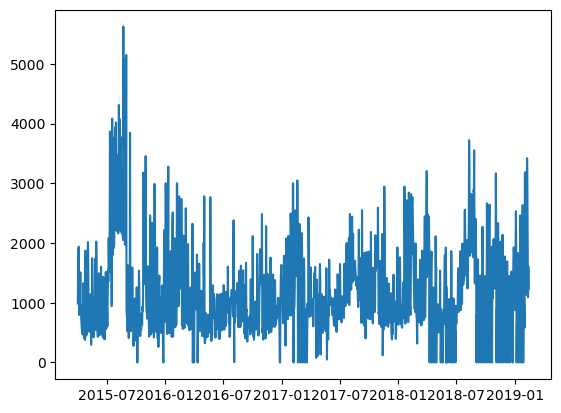

In [954]:
# loading museum visitor data - bristol museum
# https://opendata.bristol.gov.uk/datasets/98d95d36536343eca59e6e4bb04c58b7_0/explore

# Load the data
df2 = pd.read_csv('data/raw/Bristol_Museums_Daily_Visitor_Numbers.csv')

# Show unique values in the 'Museum' column
print(set(df2['Museum']))

# Filter the data to only include the Bristol Museum
df2 = df2[df2['Museum'] == 'Bristol Museum']

# Convert the 'Date' column to datetime format and sort
df2['Date'] = pd.to_datetime(df2['Date']).dt.date
df2.sort_values('Date', inplace=True)

# Plot the number of visitors over time
plt.plot(df2['Date'], df2['Number_of_visitors'])

## merge visitor data and tweets

In [955]:
# Merge with visitor data
merged_data = pd.merge(df2, tweet_summary_by_date, left_on='Date', right_on='date', how='left')
# merged_data.head()

merged_data['date'] = pd.to_datetime(merged_data['date'])

merged_data['day'] = merged_data['date'].dt.day_name()

merged_data['weekend'] = [True if x in ['Saturday', 'Sunday'] else False for x in merged_data['day']]

merged_data.head()

,Museum,Kpi,Number_of_visitors,Date,Comments,Date_Logged,ObjectId,date,self_counts,total_counts,likes_counts,retweet_counts,neutral_counts,positive_counts,negative_counts,Sentiment_value,day,weekend
0,Bristol Museum,visits,990.0,2015-04-01,NaN,2017/05/10 14:50:55.376+00,6854,2015-04-01,5.0,5.0,9.0,11.0,3.0,1.0,1.0,0.111940,Wednesday,False
1,Bristol Museum,visits,1452.0,2015-04-02,NaN,2017/05/10 14:50:55.380+00,6848,2015-04-02,4.0,9.0,22.0,42.0,3.0,0.0,6.0,-0.340400,Thursday,False
2,Bristol Museum,visits,1894.0,2015-04-03,NaN,2017/05/10 14:50:55.384+00,6842,2015-04-03,2.0,3.0,3.0,3.0,0.0,1.0,2.0,-0.149767,Friday,False
3,Bristol Museum,visits,1939.0,2015-04-04,NaN,2017/05/10 14:50:55.387+00,6836,2015-04-04,3.0,2.0,12.0,5.0,1.0,1.0,0.0,0.064000,Saturday,True
4,Bristol Museum,visits,796.0,2015-04-05,NaN,2017/05/10 14:50:55.391+00,6830,2015-04-05,1.0,3.0,5.0,2.0,1.0,2.0,0.0,0.269133,Sunday,True


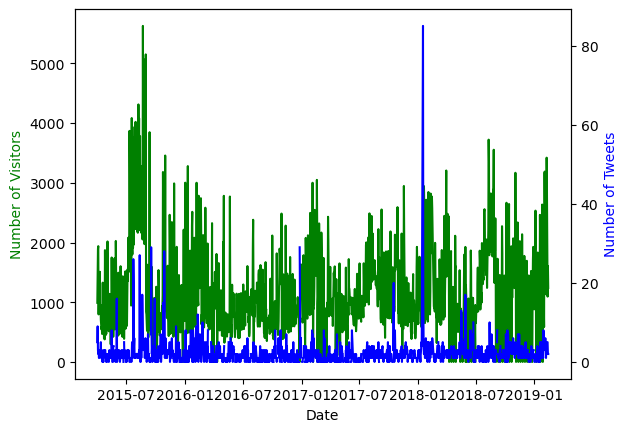

In [956]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(merged_data['Date'], merged_data['Number_of_visitors'], 'g-')
ax2.plot(merged_data['Date'], merged_data['total_counts'], 'b-')

ax1.set_xlabel('Date')
ax1.set_ylabel('Number of Visitors', color='g')
ax2.set_ylabel('Number of Tweets', color='b')

plt.show()

# spikey- are those weekends?



In [957]:
print(merged_data.total_counts.sum()) # should be ~3000
print(len(tweets)) # should be 6281

3077.0
6281


<Axes: xlabel='Number_of_visitors', ylabel='total_counts'>

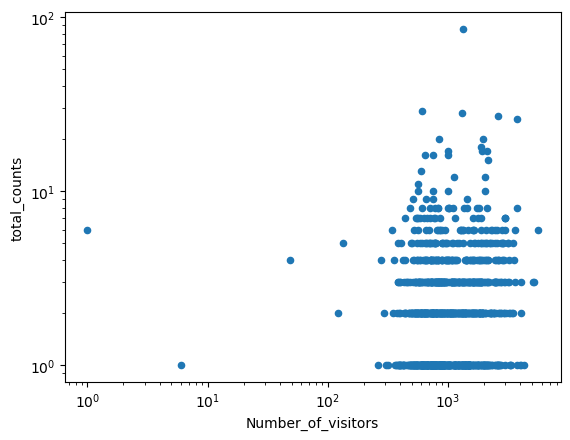

In [958]:
merged_data_clim.plot(x='Number_of_visitors', y='total_counts', kind='scatter', loglog=True)

In [959]:
# See what's causing the big spike in Jan. 2018
merged_data.sort_values('total_counts', ascending=False)
# merged_data.head()

,Museum,Kpi,Number_of_visitors,Date,Comments,Date_Logged,ObjectId,date,self_counts,total_counts,likes_counts,retweet_counts,neutral_counts,positive_counts,negative_counts,Sentiment_value,day,weekend
993,Bristol Museum,visits,1342.0,2018-01-17,the counter stopped at 4pm,2018/01/20 14:48:26.611+00,1408,2018-01-17,5.0,85.0,155.0,47.0,73.0,9.0,3.0,0.032192,Wednesday,False
167,Bristol Museum,visits,607.0,2015-09-17,NaN,2017/05/10 14:50:56.010+00,5842,2015-09-17,0.0,29.0,25.0,25.0,18.0,1.0,10.0,-0.172528,Thursday,False
634,Bristol Museum,visits,0.0,2016-12-26,NaN,2017/05/10 14:50:57.757+00,2839,2016-12-26,0.0,29.0,3.0,9.0,25.0,4.0,0.0,0.046572,Monday,False
208,Bristol Museum,visits,1315.0,2015-10-28,NaN,2017/05/10 14:50:56.163+00,5760,2015-10-28,6.0,28.0,26.0,14.0,0.0,7.0,21.0,-0.128354,Wednesday,False
131,Bristol Museum,visits,2627.0,2015-08-12,NaN,2017/05/10 14:50:55.875+00,6154,2015-08-12,1.0,27.0,8.0,4.0,26.0,0.0,1.0,-0.005733,Wednesday,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1316,Bristol Museum,visits,693.0,2018-12-13,NaN,2018/12/14 11:08:15.629+00,249,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1334,Bristol Museum,visits,1036.0,2018-12-31,md,2019/02/12 12:17:40.926+00,190,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1335,Bristol Museum,visits,1048.0,2018-12-31,NaN,2019/01/06 14:37:14.438+00,189,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1342,Bristol Museum,visits,0.0,2019-01-07,NaN,2019/02/12 12:22:44.769+00,174,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False


In [960]:
# tweets[tweets['date'] == '2018-01-17']
# tweets

merged_data.to_csv('data/processed/bristol_museum_tweets_visitors.csv', index=False)

# TODO: maybe start the script here, and put all the stuff above into a processing py script

In [722]:
from datetime import datetime as dt

start_date = dt.strptime('2018-01-17', '%Y-%m-%d').date()
end_date = dt.strptime('2018-01-17', '%Y-%m-%d').date()
# end_date = '2018-01-31'

# TODO: fix this part
# filtered_tweets = tweets[(tweets['date'] >= start_date) & (tweets['date'] <= end_date)]

tweets.head()
# Seems that the museum sold a Banksy print without that rights and that caused the spike in tweets that day
# set(filtered_tweets['Content'])

# tweets['date']



,Name,Handle,Timestamp,Verified,Content,Comments,Retweets,Likes,Analytics,Tags,Mentions,Emojis,Profile Image,Tweet Link,Tweet ID,date,Content_cleaned,Sentiment,Sentiment_value,month
0,Bristol Museum & Art Gallery,@bristolmuseum,2017-12-30T09:05:08.000Z,False,The Weather is cold outside but the welcome is...,0,3.0,7.0,0,[],[],[],https://pbs.twimg.com/profile_images/164072706...,https://x.com/bristolmuseum/status/94703078324...,tweet_id:947030783243497472,2017-12-30,The Weather is cold outside but the welcome is...,positive,0.7783,2017-12
1,Bristol Museum & Art Gallery,@bristolmuseum,2017-12-29T09:00:44.000Z,False,All 'Christmas Essentials' are now 1/2 price o...,1,2.0,5.0,0,[],[],[],https://pbs.twimg.com/profile_images/164072706...,https://x.com/bristolmuseum/status/94666729063...,tweet_id:946667290631770112,2017-12-29,All 'Christmas Essentials' are now 1/2 price o...,positive,0.6800,2017-12
2,Bristol Museum & Art Gallery,@bristolmuseum,2017-12-28T16:00:55.000Z,False,In our next #WinterLecture David Olusoga explo...,0,0.0,8.0,0,['#WinterLecture'],[],[],https://pbs.twimg.com/profile_images/164072706...,https://x.com/bristolmuseum/status/94641064325...,tweet_id:946410643258822656,2017-12-28,In our next #WinterLecture David Olusoga explo...,positive,0.6786,2017-12
3,Bristol Museum & Art Gallery,@bristolmuseum,2017-12-28T13:57:31.000Z,False,*assistance dogs that is! ^lt,0,0.0,0.0,0,[],[],[],https://pbs.twimg.com/profile_images/164072706...,https://x.com/bristolmuseum/status/94637958779...,tweet_id:946379587793096705,2017-12-28,*assistance dogs that is! ^lt,neutral,0.0000,2017-12
4,Bristol Museum & Art Gallery,@bristolmuseum,2017-12-28T13:56:17.000Z,False,"Hi Marina, thanks for checking - however only ...",2,0.0,0.0,0,[],[],[],https://pbs.twimg.com/profile_images/164072706...,https://x.com/bristolmuseum/status/94637928036...,tweet_id:946379280363159552,2017-12-28,"Hi Marina, thanks for checking - however only ...",positive,0.4404,2017-12


## Weather data

In [636]:
# Get weather data

# TODO: figure out what is going on here with my conda/pip install conflicts

from meteostat import Point, Daily
from datetime import datetime
import matplotlib.pyplot as plt

# Set time period
start = datetime(2014, 1, 1)
end = datetime(2019, 12, 31)

lat = 51.454514
lon = -2.587910
alt = 36 # feet

# Create Point for Bristol
bristol = Point(lat, lon, alt)

# Get daily data for 2014-2019
data = Daily(bristol, start, end)
data = data.fetch()

data.to_csv('data/processed/climate_bristol.csv')

# lyneham has precipitation data-
data = Daily('03740', start, end)
data = data.fetch()
data.head()

data.to_csv('data/processed/climate_lyneham.csv')


ModuleNotFoundError: No module named 'meteostat'

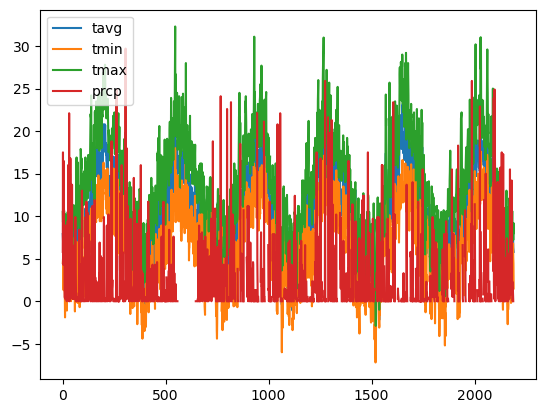

In [961]:
import matplotlib.pyplot as plt
import pandas as pd

climdat = pd.read_csv('data/processed/climate_lyneham.csv')

# Plot line chart including average, minimum and maximum temperature
climdat.plot(y=['tavg', 'tmin', 'tmax','prcp'])
plt.show()


In [962]:
# add weather data to the merged data
# Convert 'time' column to datetime
climdat['time'] = pd.to_datetime(climdat['time']).dt.date

In [963]:
# Merge weather data with the merged_data DataFrame
merged_data_clim = pd.merge(merged_data, climdat, left_on='Date', right_on='time', how='left')
# merged_data_clim.head()
merged_data_clim.columns

Index(['Museum', 'Kpi', 'Number_of_visitors', 'Date', 'Comments',
       'Date_Logged', 'ObjectId', 'date', 'self_counts', 'total_counts',
       'likes_counts', 'retweet_counts', 'neutral_counts', 'positive_counts',
       'negative_counts', 'Sentiment_value', 'day', 'weekend', 'time', 'tavg',
       'tmin', 'tmax', 'prcp', 'snow', 'wdir', 'wspd', 'wpgt', 'pres', 'tsun'],
      dtype='object')

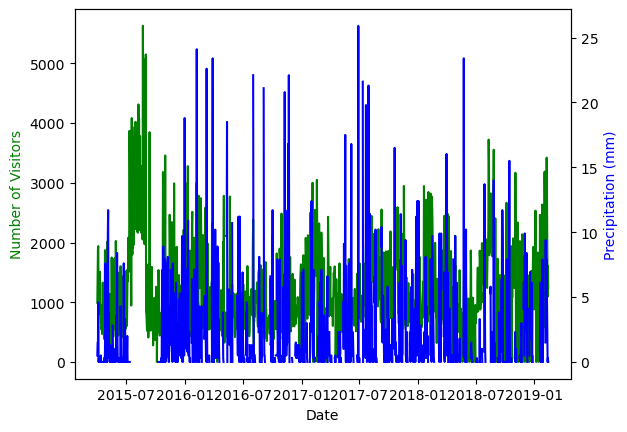

In [964]:
# Plot precipitation and visits

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(merged_data_clim['Date'], merged_data_clim['Number_of_visitors'], 'g-')
ax2.plot(merged_data_clim['Date'], merged_data_clim['prcp'], 'b-')

ax1.set_xlabel('Date')
ax1.set_ylabel('Number of Visitors', color='g')
ax2.set_ylabel('Precipitation (mm)', color='b')

plt.show()

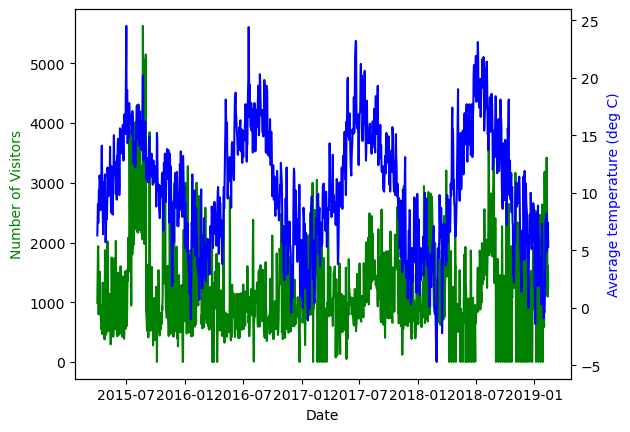

In [965]:
# Plot average temperature and museum visits

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(merged_data_clim['Date'], merged_data_clim['Number_of_visitors'], 'g-')
ax2.plot(merged_data_clim['Date'], merged_data_clim['tavg'], 'b-')

ax1.set_xlabel('Date')
ax1.set_ylabel('Number of Visitors', color='g')
ax2.set_ylabel('Average temperature (deg C)', color='b')

plt.show()

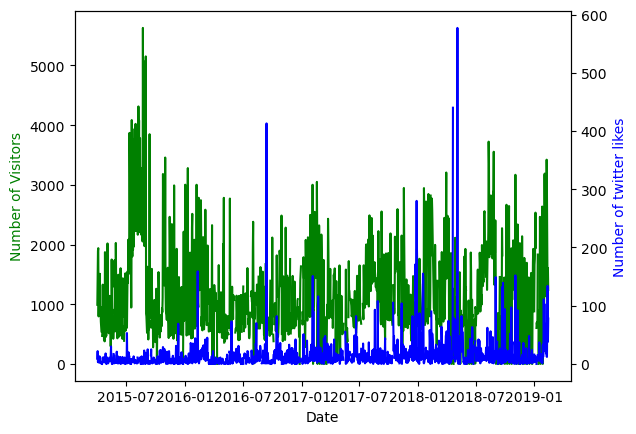

In [966]:
# Plot average temperature and museum visits

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(merged_data_clim['date'], merged_data_clim['Number_of_visitors'], 'g-')
ax2.plot(merged_data_clim['date'], merged_data_clim['likes_counts'], 'b-')

ax1.set_xlabel('Date')
ax1.set_ylabel('Number of Visitors', color='g')
ax2.set_ylabel('Number of twitter likes', color='b')

plt.show()

## Time series decomposition

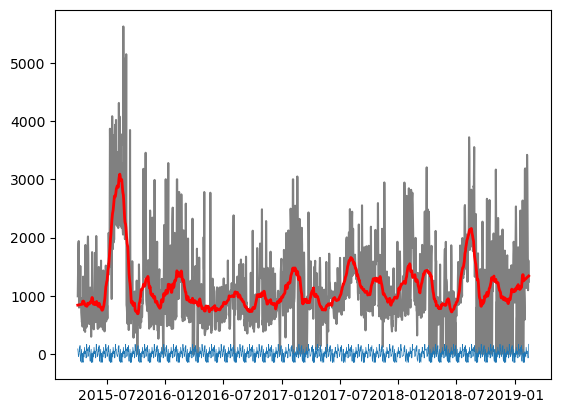

In [967]:
from statsmodels.tsa.seasonal import seasonal_decompose

# trying this out

xvar = merged_data_clim['Date']
yvar = merged_data_clim['Number_of_visitors']

ts = pd.Series(yvar.values, index=xvar)

plt.plot(ts, color='gray')

results_add = seasonal_decompose(ts, model='additive', filt=None, period=30, two_sided=True, extrapolate_trend=30)

plt.plot(results_add.trend, label='additive trend', color='red', lw=2)
plt.plot(results_add.seasonal, label='seasonal trend', lw=0.5)



,Date,Museum,Kpi,Number_of_visitors,Comments,Date_Logged,ObjectId,date,self_counts,total_counts,...,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun,trend
0,2015-04-01,Bristol Museum,visits,990.0,NaN,2017/05/10 14:50:55.376+00,6854,2015-04-01,5.0,5.0,...,2.6,9.9,0.5,NaN,268.0,25.0,NaN,1023.8,NaN,838.215255
1,2015-04-02,Bristol Museum,visits,1452.0,NaN,2017/05/10 14:50:55.380+00,6848,2015-04-02,4.0,9.0,...,5.2,9.8,1.5,NaN,225.0,14.1,NaN,1020.6,NaN,839.355356
2,2015-04-03,Bristol Museum,visits,1894.0,NaN,2017/05/10 14:50:55.384+00,6842,2015-04-03,2.0,3.0,...,7.3,12.1,1.5,NaN,243.0,11.9,NaN,1016.5,NaN,840.495457
3,2015-04-04,Bristol Museum,visits,1939.0,NaN,2017/05/10 14:50:55.387+00,6836,2015-04-04,3.0,2.0,...,6.0,8.9,4.6,NaN,18.0,16.0,NaN,1023.0,NaN,841.635558
4,2015-04-05,Bristol Museum,visits,796.0,NaN,2017/05/10 14:50:55.391+00,6830,2015-04-05,1.0,3.0,...,5.5,12.4,0.0,NaN,25.0,8.1,NaN,1027.2,NaN,842.775659
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1374,2019-02-09,Bristol Museum,visits,3421.0,NaN,2019/02/15 14:47:46.526+00,11,2019-02-09,0.0,2.0,...,4.5,8.6,7.9,NaN,234.0,22.3,67.0,1000.0,NaN,1314.743508
1375,2019-02-10,Bristol Museum,visits,2843.0,NaN,2019/02/15 14:48:03.276+00,9,2019-02-10,1.0,5.0,...,3.6,6.7,5.3,NaN,255.0,18.0,55.0,998.7,NaN,1320.795000
1376,2019-02-12,Bristol Museum,visits,1094.0,NaN,2019/02/15 14:48:16.007+00,6,2019-02-12,5.0,5.0,...,1.5,9.5,0.0,NaN,211.0,9.9,24.1,1032.9,NaN,1326.846492
1377,2019-02-13,Bristol Museum,visits,1606.0,NaN,2019/02/15 14:48:28.977+00,4,2019-02-13,2.0,2.0,...,4.2,9.7,0.3,NaN,189.0,12.4,27.8,1032.2,NaN,1332.897984


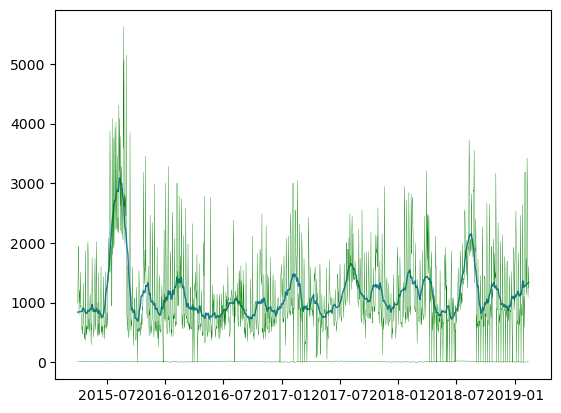

In [968]:
plt.plot(results_add.trend, label='seasonal trend', lw=1)
plt.plot(merged_data_clim['Date'], merged_data_clim['Number_of_visitors'], 'g-', lw=.25)
plt.plot(merged_data_clim['Date'], merged_data_clim['tavg'], 'g-', lw=.25)

# extract the trend
trend = results_add.trend
trend = trend.dropna()
len(trend)

# Align the trend series with the merged_data_clim DataFrame
merged_data_clim = merged_data_clim.set_index('Date')
merged_data_clim['trend'] = trend
merged_data_clim = merged_data_clim.reset_index()

merged_data_clim


## Random forest regression modeling

### Setting up all the variables

In [1133]:
# what other predictors?
# i want to make a predictive model of future trends 

# what about holidays?

# what about weekends?

# what about school holidays? NOT SURE

# what about special events?

# what about unique exhibitions?
# Create a variable to indicate if dates are within certain ranges
def is_within_date_range(date, start, end):
    return start <= date <= end

# Define the date ranges for the exhibits
exhibit_ranges = [
    ('2015-10-24', '2016-03-01'),  # death: the human experience
    ('2015-07-04', '2015-09-13')  # art in nature
    # '2016-04-22' # art from everywhere
    # '2016-05-21' # rembrandt
]

# Convert string dates to datetime.date objects
exhibit_ranges = [(dt.strptime(start, '%Y-%m-%d').date(), dt.strptime(end, '%Y-%m-%d').date()) for start, end in exhibit_ranges]

# Apply the function to create the 'exhibit' column
merged_data_clim['exhibit'] = merged_data_clim['Date'].apply(lambda x: any(is_within_date_range(x, start, end) for start, end in exhibit_ranges))

# what about marketing campaigns?

# what about twitter sentiment? (might need to account for a lag here)
# DONE

# what about the weather?
# DONE

# what about the day of the week?
# DONE

# what about the month?
merged_data_clim['month'] = merged_data_clim['date'].dt.month

# what about the year?
merged_data_clim['year'] = merged_data_clim['date'].dt.year

# what about the season?
# winter: December to February
# spring: March to May
# summer: June to August
# autumn: September to November
merged_data_clim['season'] = pd.cut(merged_data_clim['month'], bins=[0, 3, 6, 9, 12], labels=['winter', 'spring', 'summer', 'autumn'])

merged_data_clim['closed'] = [True if x ==0 else False for x in merged_data_clim['Number_of_visitors']]

merged_data_clim.head()

,Date,Museum,Kpi,Number_of_visitors,Comments,Date_Logged,ObjectId,date,self_counts,total_counts,...,pres,tsun,trend,month,year,season,fourthroot_visitors,predicted_visitors,closed,exhibit
0,2015-04-01,Bristol Museum,visits,990.0,NaN,2017/05/10 14:50:55.376+00,6854,2015-04-01,5.0,5.0,...,1023.8,NaN,838.215255,4.0,2015.0,spring,5.609302,928.529569,False,False
1,2015-04-02,Bristol Museum,visits,1452.0,NaN,2017/05/10 14:50:55.380+00,6848,2015-04-02,4.0,9.0,...,1020.6,NaN,839.355356,4.0,2015.0,spring,6.172934,1222.309635,False,False
2,2015-04-03,Bristol Museum,visits,1894.0,NaN,2017/05/10 14:50:55.384+00,6842,2015-04-03,2.0,3.0,...,1016.5,NaN,840.495457,4.0,2015.0,spring,6.596977,1452.425025,False,False
3,2015-04-04,Bristol Museum,visits,1939.0,NaN,2017/05/10 14:50:55.387+00,6836,2015-04-04,3.0,2.0,...,1023.0,NaN,841.635558,4.0,2015.0,spring,6.635818,1739.660022,False,False
4,2015-04-05,Bristol Museum,visits,796.0,NaN,2017/05/10 14:50:55.391+00,6830,2015-04-05,1.0,3.0,...,1027.2,NaN,842.775659,4.0,2015.0,spring,5.311636,954.317772,False,False


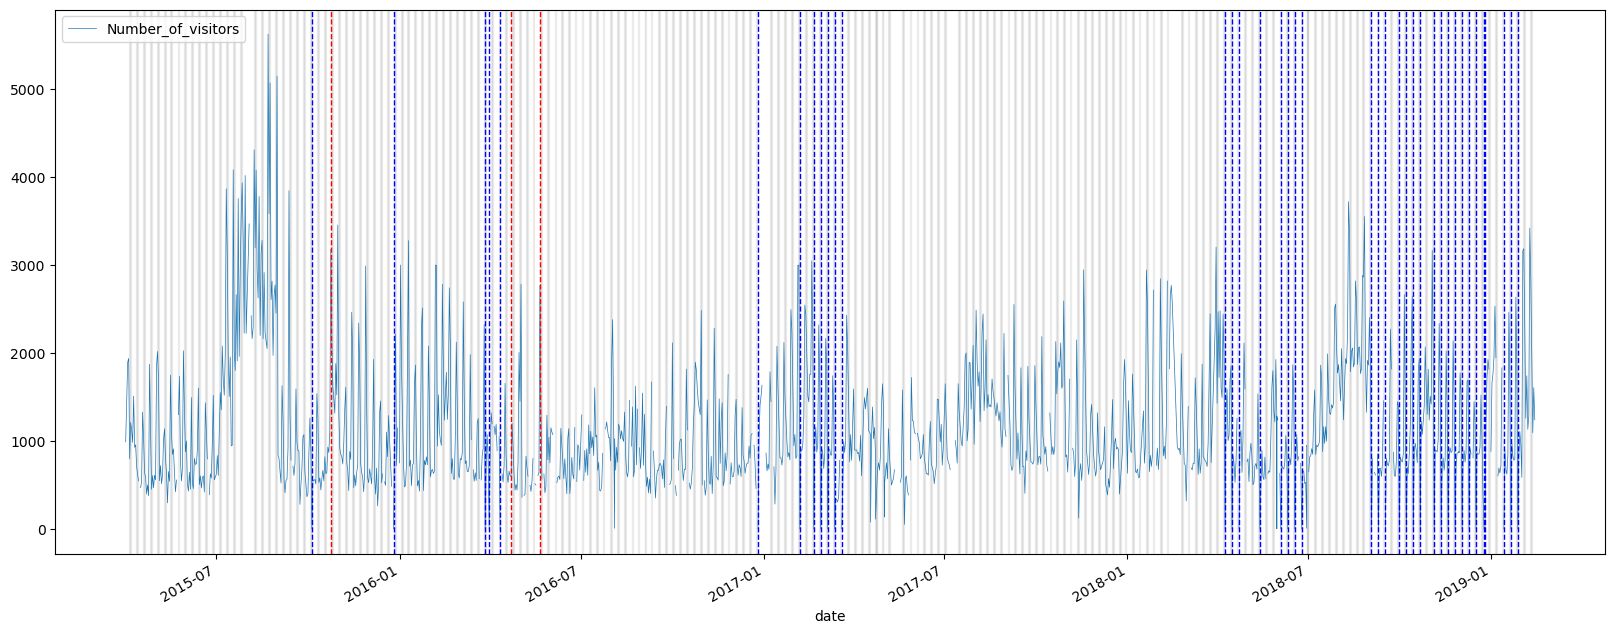

In [1134]:
merged_data_clim.plot(x='date', y='Number_of_visitors', lw=0.5, figsize=(20,8))

# Add vertical lines at events
for event in events:
    plt.axvline(pd.to_datetime(event), color='r', linestyle='--', lw=1)

# plt.xlim(pd.to_datetime('2015-10-01'), pd.to_datetime('2016-07-01'))

# Shade the weekends
for i, row in merged_data_clim.iterrows():
    if row['weekend']:
        plt.axvspan(row['date'], row['date'] + pd.Timedelta(days=1), color='gray', alpha=0.1)

# Add vertical lines if closed is True
for i, row in merged_data_clim.iterrows():
    if row['closed']:
        plt.axvline(row['date'], color='blue', linestyle='--', lw=1)

<Axes: xlabel='fourthroot_visitors', ylabel='Count'>

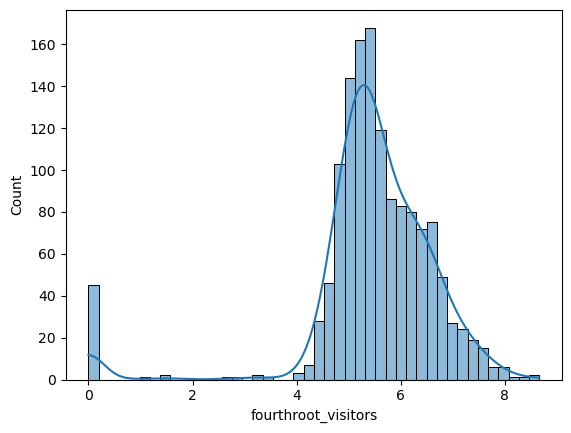

In [971]:
# Check if the number of visitors is roughly normally distributed
# sns.histplot(merged_data_clim['Number_of_visitors'], kde=True)

# log transform the number of visitors
# merged_data_clim['log_visitors'] = np.log(merged_data_clim['Number_of_visitors'])
# pow(2,2)
merged_data_clim['fourthroot_visitors'] = merged_data_clim['Number_of_visitors'].apply(lambda x: pow(x,.25))

sns.histplot(merged_data_clim['fourthroot_visitors'], kde=True)


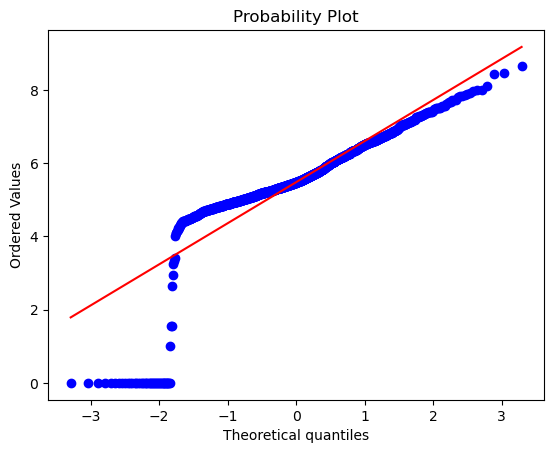

In [972]:
# make a quantiles plot
import scipy.stats as stats
import matplotlib.pyplot as plt
stats.probplot(merged_data_clim['fourthroot_visitors'], dist="norm", plot=plt)
plt.show()



<Axes: xlabel='tavg', ylabel='trend'>

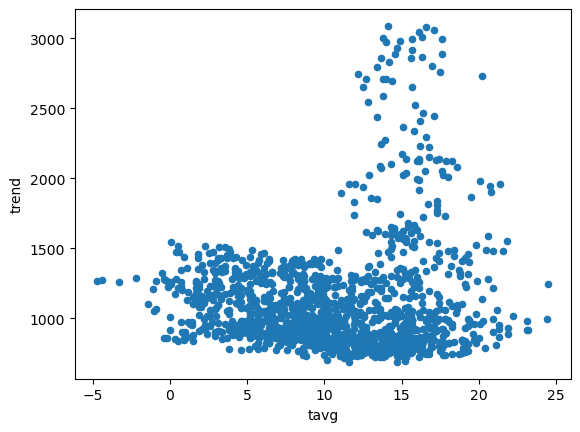

In [973]:
merged_data_clim.plot(x='tavg', y='trend', kind='scatter')

In [974]:
# get list of columns
merged_data_clim.columns

Index(['Date', 'Museum', 'Kpi', 'Number_of_visitors', 'Comments',
       'Date_Logged', 'ObjectId', 'date', 'self_counts', 'total_counts',
       'likes_counts', 'retweet_counts', 'neutral_counts', 'positive_counts',
       'negative_counts', 'Sentiment_value', 'day', 'weekend', 'time', 'tavg',
       'tmin', 'tmax', 'prcp', 'snow', 'wdir', 'wspd', 'wpgt', 'pres', 'tsun',
       'trend', 'month', 'year', 'season', 'fourthroot_visitors'],
      dtype='object')

### Clean the data set

In [1150]:
# Select relevant variables
selected_columns = ['date', 'day', 'weekend', 'Number_of_visitors', 'exhibit', 'self_counts', 'Sentiment_value', 'retweet_counts', 'closed', 'likes_counts', 'tavg', 'prcp', 'tmin', 'tmax', 'wspd']

# selected_columns2 = ['date', 'season', 'trend', 'retweet_counts', 'likes_counts', 'positive_counts', 'negative_counts', 'neutral_counts', 'tavg', 'prcp', 'tmin', 'tmax', 'wspd']

# Don't drop NAs
cleaned_data = merged_data_clim[selected_columns]

# Drop NAs
# cleaned_data = merged_data_clim[selected_columns].dropna()

cleaned_data.head()

,date,day,weekend,Number_of_visitors,exhibit,self_counts,Sentiment_value,retweet_counts,closed,likes_counts,tavg,prcp,tmin,tmax,wspd
0,2015-04-01,Wednesday,False,990.0,False,5.0,0.111940,11.0,False,9.0,6.3,0.5,2.6,9.9,25.0
1,2015-04-02,Thursday,False,1452.0,False,4.0,-0.340400,42.0,False,22.0,7.9,1.5,5.2,9.8,14.1
2,2015-04-03,Friday,False,1894.0,False,2.0,-0.149767,3.0,False,3.0,9.0,1.5,7.3,12.1,11.9
3,2015-04-04,Saturday,True,1939.0,False,3.0,0.064000,5.0,False,12.0,7.4,4.6,6.0,8.9,16.0
4,2015-04-05,Sunday,True,796.0,False,1.0,0.269133,2.0,False,5.0,8.8,0.0,5.5,12.4,8.1


In [1151]:
cleaned_data = pd.get_dummies(cleaned_data, columns=['day'])
# cleaned_data = pd.get_dummies(cleaned_data, columns=['season'])
cleaned_data.head()

,date,weekend,Number_of_visitors,exhibit,self_counts,Sentiment_value,retweet_counts,closed,likes_counts,tavg,...,tmin,tmax,wspd,day_Friday,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday
0,2015-04-01,False,990.0,False,5.0,0.111940,11.0,False,9.0,6.3,...,2.6,9.9,25.0,False,False,False,False,False,False,True
1,2015-04-02,False,1452.0,False,4.0,-0.340400,42.0,False,22.0,7.9,...,5.2,9.8,14.1,False,False,False,False,True,False,False
2,2015-04-03,False,1894.0,False,2.0,-0.149767,3.0,False,3.0,9.0,...,7.3,12.1,11.9,True,False,False,False,False,False,False
3,2015-04-04,True,1939.0,False,3.0,0.064000,5.0,False,12.0,7.4,...,6.0,8.9,16.0,False,False,True,False,False,False,False
4,2015-04-05,True,796.0,False,1.0,0.269133,2.0,False,5.0,8.8,...,5.5,12.4,8.1,False,False,False,True,False,False,False


### Partition the data into training and test data sets

In [1152]:
from sklearn.model_selection import train_test_split

# Randomly split 20% of rows as testing (or validation) and the other as training
train_data, test_data = train_test_split(cleaned_data, test_size=0.2, random_state=42)

# Selecting columns for regressions
X_train = train_data.drop(columns=['date', 'Number_of_visitors'])
y_train = train_data['Number_of_visitors']

X_test = test_data.drop(columns=['date', 'Number_of_visitors'])
y_test = test_data['Number_of_visitors']

len(train_data), len(test_data)

(1103, 276)

### Fit a decision tree regressor model

In [1028]:
from sklearn import model_selection
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from math import sqrt

# Do decision tree regression
dtree = DecisionTreeRegressor(max_depth=None, random_state=42)
dtree.fit(X_train, y_train)


DecisionTreeRegressor(random_state=42)

In [1029]:
# Output R2, MSE for training and testing data-

# training data
pred_train_tree = dtree.predict(X_train)
print(np.sqrt(mean_squared_error(y_train,pred_train_tree)))
print(r2_score(y_train, pred_train_tree))

# validation/testing data
pred_test_tree = dtree.predict(X_test)
print(np.sqrt(mean_squared_error(y_test,pred_test_tree))) 
print(r2_score(y_test, pred_test_tree))


145.61063936250528
0.9598718682751961
787.4435492764554
-0.21960655053401723


In [986]:
# TODO: learn how to do this with tensorflow decision forests

# import tensorflow as tf
# import tensorflow_decision_forests as tfdf

# Convert datasetes into TensorFlow datasets
# train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_data, label='Number_of_visitors')
# test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_data, label='Number_of_visitors')



### Fit a random forest regression model

#### hyperparameter tuning

In [ ]:
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV

param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}
rf = RandomForestRegressor()

rand_search = RandomizedSearchCV(rf, param_distributions=param_dist, n_iter=5, cv=5, verbose=0, random_state=42)

rand_search.fit(X_train, y_train)

#### Fit model

In [1153]:
model_rf = RandomForestRegressor(n_estimators=5000, oob_score=True, random_state=100, min_samples_leaf=2)
model_rf.fit(X_train, y_train)

RandomForestRegressor(min_samples_leaf=2, n_estimators=5000, oob_score=True,
                      random_state=100)

In [1154]:
# extract R2, model fits
pred_train_rf= model_rf.predict(X_train)
print(np.sqrt(mean_squared_error(y_train,pred_train_rf)))
print(r2_score(y_train, pred_train_rf))

pred_test_rf = model_rf.predict(X_test)
print(np.sqrt(mean_squared_error(y_test,pred_test_rf)))
print(r2_score(y_test, pred_test_rf))

264.2124943355883
0.8678797383800468
540.829922649661
0.42468948340807167


$R^2$ is 87.6% for the training set (not bad??), but $R^2$ for the test data is rather low at 46.4%. I probably need to take a look at what's going on there.

#### Plot the predicted and actual number of visitors for the RF model

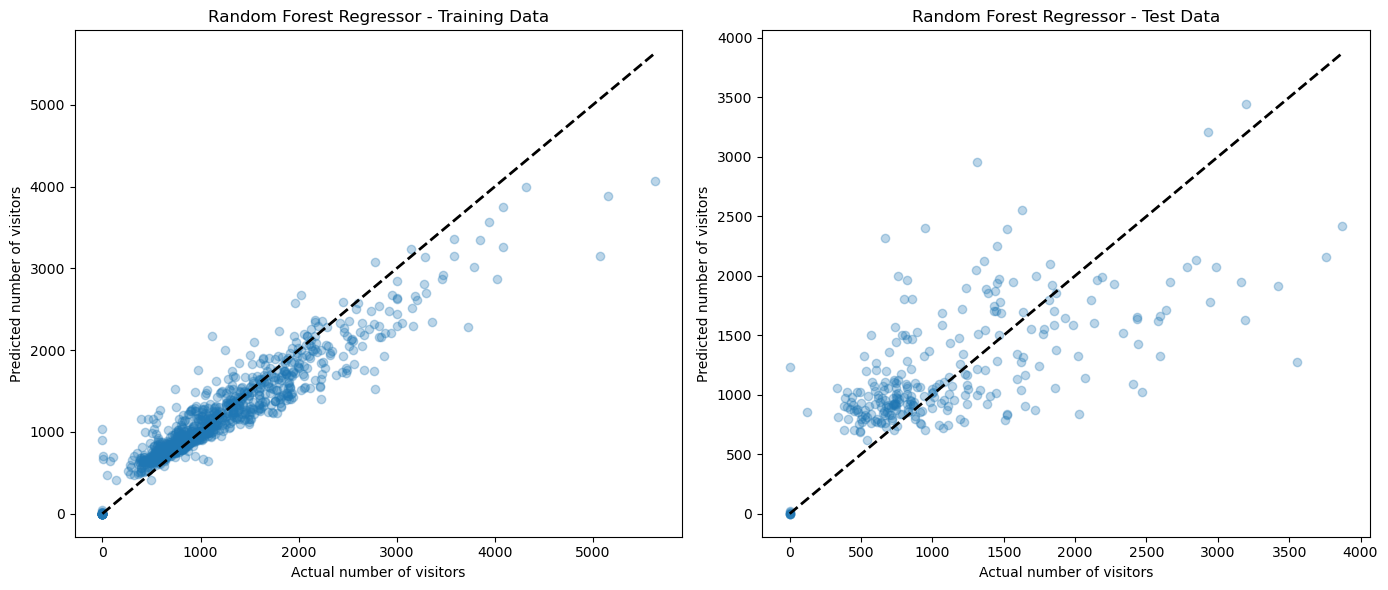

In [1155]:
# Setup figure
plt.figure(figsize=(14, 6))

# Plotting the training data predictions
plt.subplot(1, 2, 1)
plt.scatter(y_train, pred_train_rf, alpha=0.3)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=2)
plt.xlabel('Actual number of visitors')
plt.ylabel('Predicted number of visitors')
plt.title('Random Forest Regressor - Training Data')

# Plotting the test data predictions
plt.subplot(1, 2, 2)
plt.scatter(y_test, pred_test_rf, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual number of visitors')
plt.ylabel('Predicted number of visitors')
plt.title('Random Forest Regressor - Test Data')

# Some layout updates
plt.tight_layout()
plt.show()

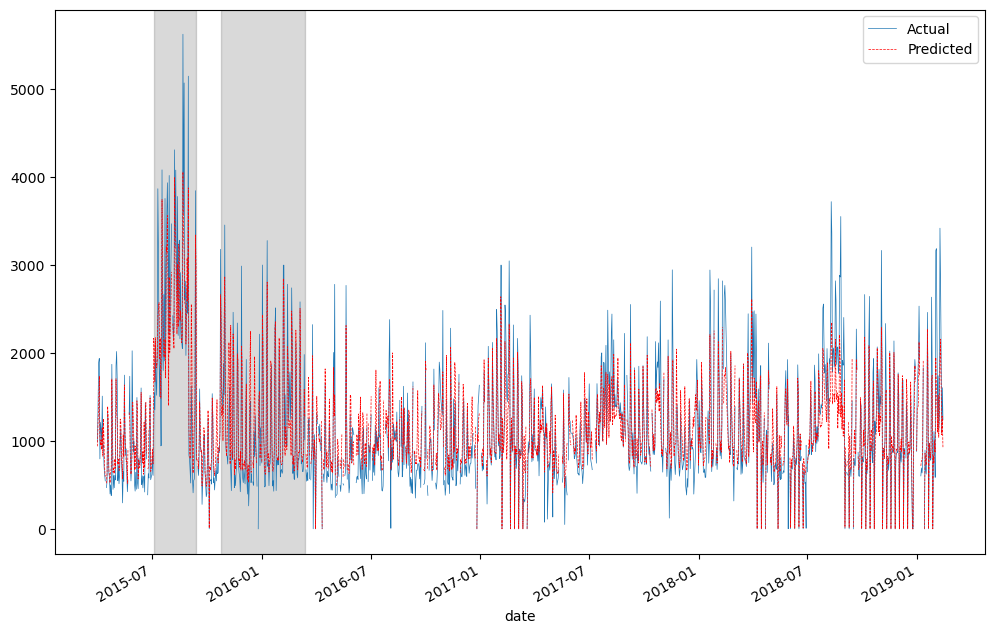

In [1156]:
# Plot actual and predicted values

# plt.scatter(merged_data_clim['date'], pred_train_rf, alpha=0.3)
# X_train.index

# TODO: probably would be better to write a function that prepares the data set for RF modeling

# Merge the training and testing data
tmp = pd.concat([X_train, X_test], axis=0)
tmp = tmp.loc[merged_data_clim.index]

# Get predictions and add to the main data set
merged_data_clim['predicted_visitors'] = model_rf.predict(tmp)

# Plots
merged_data_clim.plot(x='date', y='Number_of_visitors', lw=0.5, figsize=(12,8), kind='line')
plt.plot(merged_data_clim['date'], merged_data_clim['predicted_visitors'], lw=0.5, color='red', linestyle='--')

# Optionally limit to a time range
# plt.xlim(pd.to_datetime('2015-01-01'), pd.to_datetime('2015-12-31'))

# Add a legend
plt.legend(['Actual', 'Predicted'])

# Add vertical lines at new years
# for year in range(2015, 2020):
#     plt.axvline(pd.to_datetime(f'{year}-01-01'), color='gray', linestyle='--', lw=1)

# plt.savefig('figs/visitors_predicted.png', dpi=300)

# Add shaded box for range of dates
axes = plt.gcf().get_axes()
for ax in axes:
    ax.axvspan(pd.to_datetime('2015-10-24'), pd.to_datetime('2016-03-13'), color='black', alpha=0.15) # death: the human experience
    ax.axvspan(pd.to_datetime('2015-07-04'), pd.to_datetime('2015-09-13'), color='black', alpha=0.15) # art forms in nature exhibit



In [1144]:
# Looking at where the zeros come from
merged_data_clim[merged_data_clim['Number_of_visitors'] == 0].groupby('day').size()
# most are Mondays, looking online that's when the museum is often closed (but not always as seen in the time series above)

day
Monday       34
Saturday      1
Sunday        1
Thursday      1
Tuesday       1
Wednesday     1
dtype: int64

#### Look at RF decision tree

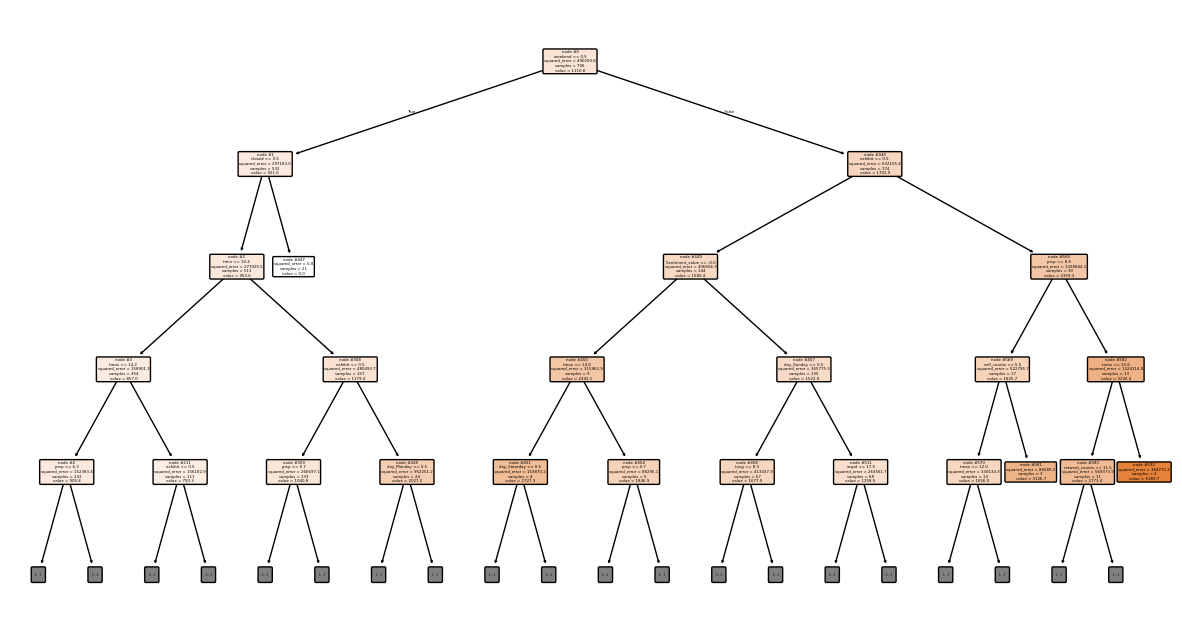

In [1157]:
# import pybaobabdt

# Get the feature names
feature_names = X_train.columns

# Pick the first tree from the forest
dtree1 = model_rf.estimators_[0]

# Plot the tree
plt.figure(figsize=(15, 8))
tree.plot_tree(dtree1, feature_names=feature_names, max_depth=4, filled=True, node_ids=True, rounded=True, precision=1)

# text_representation = tree.export_text(dtree1, feature_names=feature_names)
# print(text_representation)

plt.savefig('figs/tree.png', dpi=600)

# Another way
# m = dtreeviz.model(dtree1, X_train, y_train, feature_names=feature_names, target_name='Number_of_visitors')
# m.view(depth_range_to_display=[0,1,2])


#### Get feature importances

In [1158]:
importances = model_rf.feature_importances_

# Create a DataFrame for better visualization
feature_importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})

# Sort the DataFrame by importance
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

print(feature_importances)

            Feature  Importance
0           weekend    0.198500
1           exhibit    0.126428
7              tavg    0.114934
10             tmax    0.080406
9              tmin    0.076090
8              prcp    0.066691
3   Sentiment_value    0.063986
11             wspd    0.060750
5            closed    0.059623
6      likes_counts    0.049394
4    retweet_counts    0.039454
2       self_counts    0.026713
13       day_Monday    0.014673
14     day_Saturday    0.006223
15       day_Sunday    0.005461
16     day_Thursday    0.003153
12       day_Friday    0.002792
18    day_Wednesday    0.002462
17      day_Tuesday    0.002265


In [1159]:
# range of visitors per day
merged_data_clim['Number_of_visitors'].min(), merged_data_clim['Number_of_visitors'].max()

(0.0, 5628.0)